In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [3]:
dataset = '../annotation/step2_output.csv'
model_save_path = '../model/point_history_center.hdf5'

In [4]:
NUM_CLASSES = 5
TIME_STEPS = 4
DIMENSION = 2

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
print(X_dataset.shape)

(3726, 8)


In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
print(y_dataset.shape)

(3726,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2794, 8)
(2794,)
(932, 8)
(932,)


# Model building

In [8]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(32, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

2023-01-12 13:22:26.670085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 13:22:27.180398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 13:22:27.181168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 13:22:27.209383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 2)              0         
                                                                 
 dropout (Dropout)           (None, 4, 2)              0         
                                                                 
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainabl

In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/2000


2023-01-12 13:22:36.273647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-12 13:22:37.350948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-12 13:22:37.691155: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f89ec00eae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-12 13:22:37.691180: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-01-12 13:22:37.910237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-12 13:22:38.996363: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1.

35/88 [==========>...................] - ETA: 0s - loss: 1.6100 - accuracy: 0.0688 

2023-01-12 13:22:40.692650: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-12 13:22:40.693121: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-12 13:22:40.703760: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

88/88 [==============================] - ETA: 0s - loss: 1.6058 - accuracy: 0.1664
Epoch 1: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 10s 8ms/step - loss: 1.6058 - accuracy: 0.1664 - val_loss: 1.5972 - val_accuracy: 0.3273
Epoch 2/2000
72/88 [=======================>......] - ETA: 0s - loss: 1.5941 - accuracy: 0.3863
Epoch 2: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 1.5926 - accuracy: 0.4044 - val_loss: 1.5859 - val_accuracy: 0.5000
Epoch 3/2000
88/88 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.4911
Epoch 3: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 1.5818 - accuracy: 0.4911 - val_loss: 1.5753 - val_accuracy: 0.5343
Epoch 4/2000
86/88 [============================>.] - ETA: 0s - loss: 1.5702 - accuracy: 0.5007
Epoch 4: saving model to ../model/point_history_center.hdf5
8

Epoch 30/2000
88/88 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9463
Epoch 30: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.2680 - accuracy: 0.9463 - val_loss: 0.2235 - val_accuracy: 0.9785
Epoch 31/2000
87/88 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9476
Epoch 31: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.2536 - accuracy: 0.9474 - val_loss: 0.2084 - val_accuracy: 0.9828
Epoch 32/2000
88/88 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9549
Epoch 32: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.2436 - accuracy: 0.9549 - val_loss: 0.1941 - val_accuracy: 0.9839
Epoch 33/2000
88/88 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9513
Epoch 33: saving model to ../model/point_h

88/88 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9621 - val_loss: 0.0793 - val_accuracy: 0.9861
Epoch 59/2000
71/88 [=======================>......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9604
Epoch 59: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1405 - accuracy: 0.9603 - val_loss: 0.0774 - val_accuracy: 0.9850
Epoch 60/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9576
Epoch 60: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9578 - val_loss: 0.0760 - val_accuracy: 0.9861
Epoch 61/2000
72/88 [=======================>......] - ETA: 0s - loss: 0.1243 - accuracy: 0.9640
Epoch 61: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9628 - val_loss: 0.0749 - val_accuracy: 0.9850
Epoch 62/2

72/88 [=======================>......] - ETA: 0s - loss: 0.1328 - accuracy: 0.9622
Epoch 87: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9624 - val_loss: 0.0576 - val_accuracy: 0.9871
Epoch 88/2000
71/88 [=======================>......] - ETA: 0s - loss: 0.1313 - accuracy: 0.9608
Epoch 88: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9624 - val_loss: 0.0595 - val_accuracy: 0.9861
Epoch 89/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9573
Epoch 89: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1345 - accuracy: 0.9574 - val_loss: 0.0571 - val_accuracy: 0.9850
Epoch 90/2000
71/88 [=======================>......] - ETA: 0s - loss: 0.1296 - accuracy: 0.9599
Epoch 90: saving model to ../model/point_history_center.

88/88 [==============================] - 0s 4ms/step - loss: 0.1094 - accuracy: 0.9660 - val_loss: 0.0519 - val_accuracy: 0.9861
Epoch 116/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9659
Epoch 116: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9660 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 117/2000
88/88 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9624
Epoch 117: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9624 - val_loss: 0.0504 - val_accuracy: 0.9861
Epoch 118/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9677
Epoch 118: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1113 - accuracy: 0.9678 - val_loss: 0.0525 - val_accuracy: 0.9871
Epoc

Epoch 144/2000
71/88 [=======================>......] - ETA: 0s - loss: 0.0949 - accuracy: 0.9692
Epoch 144: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.0967 - accuracy: 0.9689 - val_loss: 0.0465 - val_accuracy: 0.9903
Epoch 145/2000
88/88 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9603
Epoch 145: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1167 - accuracy: 0.9603 - val_loss: 0.0458 - val_accuracy: 0.9903
Epoch 146/2000
71/88 [=======================>......] - ETA: 0s - loss: 0.1001 - accuracy: 0.9661
Epoch 146: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1038 - accuracy: 0.9653 - val_loss: 0.0461 - val_accuracy: 0.9903
Epoch 147/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9673
Epoch 147: saving model to ../model

88/88 [==============================] - 0s 4ms/step - loss: 0.0992 - accuracy: 0.9667 - val_loss: 0.0443 - val_accuracy: 0.9893
Epoch 173/2000
88/88 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9628
Epoch 173: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.9628 - val_loss: 0.0441 - val_accuracy: 0.9903
Epoch 174/2000
88/88 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9667
Epoch 174: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9667 - val_loss: 0.0446 - val_accuracy: 0.9903
Epoch 175/2000
85/88 [===========================>..] - ETA: 0s - loss: 0.1060 - accuracy: 0.9632
Epoch 175: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1049 - accuracy: 0.9631 - val_loss: 0.0436 - val_accuracy: 0.9903
Epoc

Epoch 201/2000
72/88 [=======================>......] - ETA: 0s - loss: 0.0995 - accuracy: 0.9679
Epoch 201: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.0970 - accuracy: 0.9674 - val_loss: 0.0419 - val_accuracy: 0.9903
Epoch 202/2000
87/88 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9677
Epoch 202: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9678 - val_loss: 0.0415 - val_accuracy: 0.9882
Epoch 203/2000
86/88 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9662
Epoch 203: saving model to ../model/point_history_center.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9664 - val_loss: 0.0418 - val_accuracy: 0.9903
Epoch 204/2000
88/88 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9535
Epoch 204: saving model to ../model

In [13]:
model = tf.keras.models.load_model(model_save_path)

In [14]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 243ms/step
[9.1396994e-04 9.9809271e-01 9.5581927e-04 3.7109090e-05 3.1582712e-07]
1


# Confusion matrix

30/30 [==============================] - 0s 1ms/step


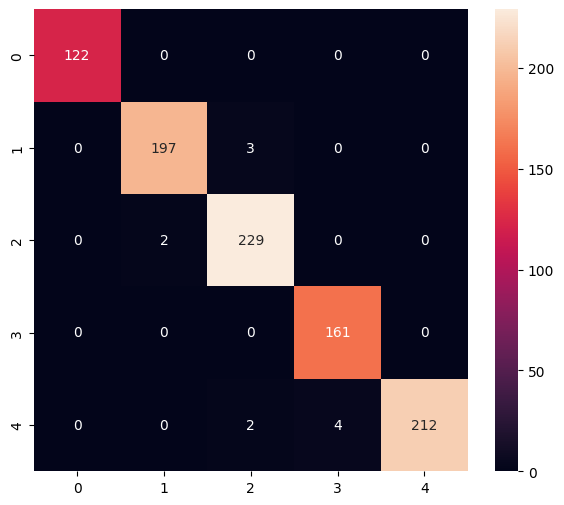

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       0.99      0.98      0.99       200
           2       0.98      0.99      0.98       231
           3       0.98      1.00      0.99       161
           4       1.00      0.97      0.99       218

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
# Save the model.
with open('../model/lstm_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpm_my0dd3/assets


INFO:tensorflow:Assets written to: /tmp/tmpm_my0dd3/assets
2023-01-12 13:25:50.161736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-12 13:25:50.161767: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-12 13:25:50.161906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm_my0dd3
2023-01-12 13:25:50.173221: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-12 13:25:50.173252: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm_my0dd3
2023-01-12 13:25:50.204158: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-12 13:25:50.261124: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm_my0dd3
2023-01-12 13:25:50.296816: I tensorflow/cc/saved_model/loader.cc:305] SavedModel